In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import subprocess
from glob import glob

from pkg import u,m

torch.set_printoptions(profile="full")

# dataset_num = input("Enter dataset number: ")
# dataset = dataset_num.zfill(2) # string (ex '01')
dataset = '01'

pm = u.PathManager(dataset=dataset)
p = u.Processor(paths=pm, dataset=dataset)
clen, photon_energy = p.get_parameters()
print(f"clen: {clen}, photon_energy: {photon_energy}")
# instances
pm = u.PathManager(dataset=dataset)
peak_paths, water_peak_paths, labels, water_background_path = pm.select_dataset(dataset=dataset)
p = u.Processor(paths=pm, dataset=dataset)

clen: 1.5, photon_energy: 6000


In [7]:
u.get_counts(pm)
%run process_directory.py ../../images  --percent_empty 0.4 --f
u.get_counts(pm)


Paths refreshed for dataset 01.
Directory: peaks/01
  Total files: 60
  Normal images: 60
  Empty images: 0
Directory: labels/01
  Total files: 10
  Normal images: 10
  Empty images: 0
Directory: peaks_water_overlay/01
  Total files: 10
  Normal images: 10
  Empty images: 0
Directories '01' through '09' already created in '../../images/labels'.
Directories '01' through '09' already created in '../../images/peaks'.
Directories '01' through '09' already created in '../../images/peaks_water_overlay'.
Directories '01' through '09' already created in '../../images/water'.
Mismatch found in dataset 01: Peaks: 60, Labels: 10, Overlays: 10.

Directories for dataset 02 are ready for processing (Step 1).
Directories for dataset 03 are ready for processing (Step 1).
Directories for dataset 04 are ready for processing (Step 1).
Directories for dataset 05 are ready for processing (Step 1).
Directories for dataset 06 are ready for processing (Step 1).
Directories for dataset 07 are ready for process

In [8]:
dm = u.DatasetManager(paths=pm, dataset=dataset, parameters=(clen, photon_energy), transform=None)

# peak, label, overlay are valid types
u.check_attributes(paths=pm, dataset=dataset, type='peak') 
u.check_attributes(paths=pm, dataset=dataset, type='overlay')
u.check_attributes(paths=pm, dataset=dataset, type='label')

train_loader, test_loader = u.prepare(data_manager=dm, batch_size=10)

Paths refreshed for dataset 01.
Directory: peaks/01
  Total files: 84
  Normal images: 60
  Empty images: 24
Directory: labels/01
  Total files: 84
  Normal images: 60
  Empty images: 24
Directory: peaks_water_overlay/01
  Total files: 84
  Normal images: 60
  Empty images: 24
Paths refreshed for dataset 01.
Actual percentage of empty images: 28.57142857142857% across peaks, water_overlays, and labels directories.

All files in dataset 01 of type 'peak' have matching attributes.
All files in dataset 01 of type 'label' have matching attributes.
All files in dataset 01 of type 'overlay' have matching attributes.
File /home/eseverett/Desktop/CXFEL/cxls_hitfinder/images/water/01/water01.h5 has mismatching attributes: clen=None, photon_energy=None


ValueError: Dataset 01 failed authentication.

In [ ]:
dir(m)

['BasicCNN1',
 'BasicCNN2',
 'BasicCNN3',
 'DenseNet121_Weights',
 'DenseNetBraggPeakClassifier',
 'F',
 'ResNet50BraggPeakClassifier',
 'ResNet50_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'models',
 'nn',
 'np',
 'optim',
 'os',
 'torch']

In [ ]:
model1 = m.BasicCNN3()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = {
    'num_epochs': 2,
    'num_classes': 2,
    'batch_size': train_loader.batch_size,
    'test_size': len(train_loader.dataset),
    'test_size': len(test_loader.dataset),
    'criterion': criterion,
    'optimizer': optimizer,
    'device': device,
    'model': model1,
}

# # arguments: self, model, loader: list, criterion, optimizer, device, cfg: dict
t = u.TrainTestModels(model=model1, loader=[train_loader, test_loader], criterion=criterion, optimizer=optimizer, device=device, cfg=cfg)

In [ ]:
t.epoch_loop()

Model testing and validating: BasicCNN3
-- epoch 0


36
15
20
17
4
Train loss: 0.2326079338788986
Train accuracy: 0.6000000238418579
Test loss: 0.1006408840417862
Test accuracy: 0.5
-- epoch 1
17
36
17
16
6
Train loss: 0.27059648633003236
Train accuracy: 0.4000000059604645
Test loss: 0.1006408840417862
Test accuracy: 0.5


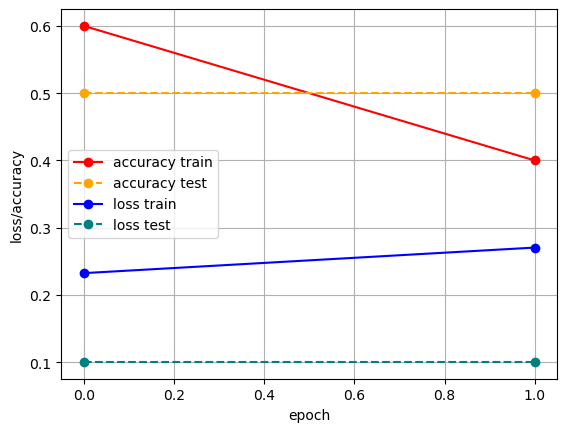

In [ ]:
t.plot_loss_accuracy()

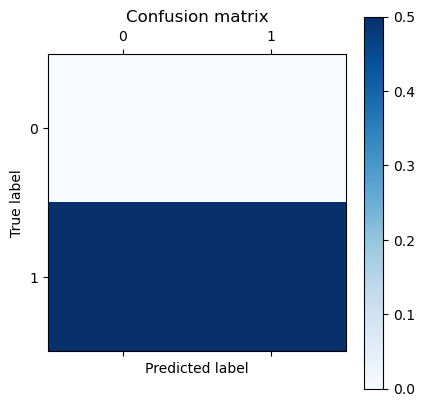

In [ ]:
t.plot_confusion_matrix()

In [ ]:
t.get_confusion_matrix()

array([[0. , 0. ],
       [0.5, 0.5]])

In [ ]:
# for i, j in test_loader:
#     print(i[0])
#     print(j[9])
#     break